Notes:
- Using pandas.cut for binning. bin_min=-inf, bin_max=inf. Binning on normalized data only. (Other option to explore: sklearn KBinsDiscretizer. Issue is that bins cant be predefined. We need same bins for each batch of y. advantage: inverse is easily available)

- Changing y to categorical only for training. not for valid, test. so shape of y will be different. shape[batch_size, lat, lon, variable, member] Is shape ok?

- Please check custom loss function in networks.py,  train(), build_resnet_categorical(), create_predictions(), DataGenerator(), load_data() 

ToDo
- currently works only for 2 output variables.
- use diff. in temp instead of absolute values.
- we may use bins in powers of 2, like 256.
- add binned_crps to score.py



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.networks import *

In [3]:
tf.__version__ #gotta check. some issue. not able to use gpu.

'2.0.0'

In [4]:
import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [6]:
args = load_args('../nn_configs/B/81.1-resnet_d3_dr_0.1.yml')

In [7]:
args['train_years']=['2017', '2017']
#args['valid_years']=['2018']
args['valid_years']=['2018-01-01','2018-03-31']
args['test_years']=['2018-04-01','2018-12-31']
# args['model_save_dir'] ='/home/garg/data/WeatherBench/predictions/saved_models'
# args['datadir']='/home/garg/data/WeatherBench/5.625deg'

In [8]:
args['is_categorical']=True
args['num_bins'], args['bin_min'], args['bin_max']
#num_bins=args['num_bins']

(50, -5, 5)

In [9]:
args['filters'] = [128, 128, 128, 128, 128, 128, 128, 128, 
                   128, 128, 128, 128, 128, 128, 128, 128, 
                   128, 128, 128, 128, 2*args['num_bins']]
args['loss'] = 'lat_categorical_loss'
#could change it directly in build_resnet_categorical fn. Should we?

In [12]:
# args['model_save_dir'] ='/home/garg/data/WeatherBench/predictions/saved_models'
# args['datadir']='/home/garg/data/WeatherBench/5.625deg'

In [13]:
dg_train, dg_valid, dg_test = load_data(**args)

In [14]:
x,y=dg_train[0]; print(x.shape, y.shape)
x,y=dg_valid[0]; print(x.shape, y.shape) 
x,y=dg_test[0]; print(x.shape, y.shape)
#only changing train shape.

(32, 32, 64, 114) (32, 32, 64, 2, 50)
(32, 32, 64, 114) (32, 32, 64, 2, 50)
(32, 32, 64, 114) (32, 32, 64, 2, 50)


In [15]:
x,y=dg_train[0]; print(x.shape, y.shape)

(32, 32, 64, 114) (32, 32, 64, 2, 50)


In [16]:
y[0, 0, 0, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)

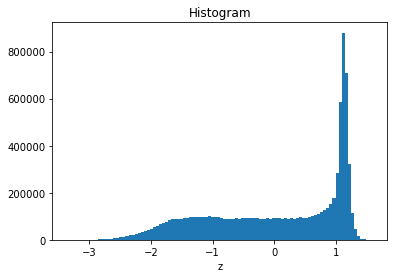

In [39]:
dg_train.data.isel(level=dg_train.output_idxs[0]).plot.hist(bins=100);

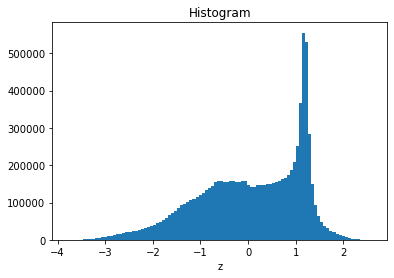

In [40]:
dg_train.data.isel(level=dg_train.output_idxs[1]).plot.hist(bins=100);

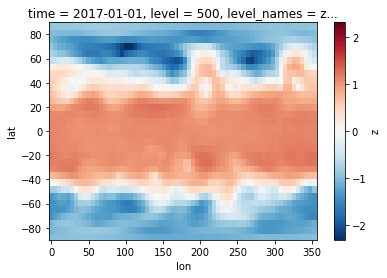

In [42]:
dg_train.data.isel(time=0, level=dg_train.output_idxs[0]).plot()

## Training

In [17]:
tf.keras.losses.ca

AttributeError: module 'tensorflow_core.keras.losses' has no attribute 'ca'

In [14]:
model = build_resnet_categorical(
    **args, input_shape=dg_train.shape,
)
# model.summary()

In [18]:
categorical_loss = create_lat_categorical_loss(dg_train.data.lat, 2)

In [17]:
model.compile(keras.optimizers.Adam(1e-3), loss=categorical_loss)

In [18]:
model.fit(dg_train, epochs=10)

  ...
    to  
  ['...']
Train for 136 steps
Epoch 1/10
136/136 [==============================] - 37s 270ms/step - loss: 5.5305
Epoch 2/10
136/136 [==============================] - 26s 193ms/step - loss: 3.5370
Epoch 3/10
136/136 [==============================] - 26s 193ms/step - loss: 3.3804
Epoch 4/10
136/136 [==============================] - 27s 196ms/step - loss: 3.1863
Epoch 5/10
136/136 [==============================] - 26s 191ms/step - loss: 3.0382
Epoch 6/10
136/136 [==============================] - 26s 190ms/step - loss: 2.9138
Epoch 7/10
136/136 [==============================] - 26s 190ms/step - loss: 2.8702
Epoch 8/10
136/136 [==============================] - 26s 189ms/step - loss: 2.7495
Epoch 9/10
136/136 [==============================] - 26s 190ms/step - loss: 2.8390
Epoch 10/10
136/136 [==============================] - 25s 187ms/step - loss: 2.9271


In [19]:
#exp_id=args['exp_id']
# exp_id='categorical_v3'
# model_save_dir=args['model_save_dir']

# model.save(f'{model_save_dir}/{exp_id}.h5')
# model.save_weights(f'{model_save_dir}/{exp_id}_weights.h5')
# #to_pickle(history.history, f'{model_save_dir}/{exp_id}_history.pkl')

## Predictions

In [62]:
preds = model.predict(dg_valid)

In [23]:
preds.shape

(1042, 32, 64, 2, 50)

<BarContainer object of 50 artists>

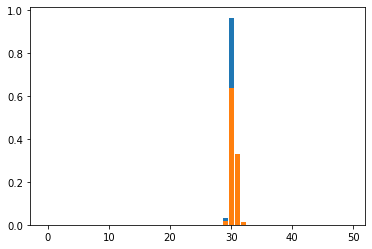

In [27]:
plt.bar(np.arange(50), preds[0, 16, 0, 0])
plt.bar(np.arange(50), preds[0, 16, 0, 1])

In [93]:
bin_min=args['bin_min']; bin_max=args['bin_max']
num_bins=args['num_bins']

preds = create_predictions(model, dg_valid, is_categorical=True, 
                           num_bins=num_bins, bin_min=bin_min, 
                           bin_max=bin_max)

<BarContainer object of 50 artists>

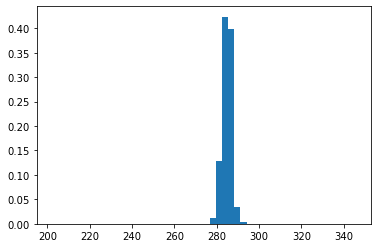

In [94]:
plt.bar(preds.t.mid_points, preds.t.isel(time=0, lat=10, lon=10), width=preds.t.bin_width)

## Load fully trained model

In [10]:
args = load_args('../nn_configs/C/001-resnet_d3_categorical.yml')

In [11]:
args['ext_mean'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_mean.nc')
args['ext_std'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_std.nc')

In [12]:
dg_test = load_data(**args, only_test=True)

In [13]:
model = keras.models.load_model(
    f'{args["model_save_dir"]}/{args["exp_id"]}.h5',
    custom_objects={'PeriodicConv2D': PeriodicConv2D, 'categorical_loss': keras.losses.mse}
)

In [14]:
# Predict
preds = create_predictions(model, dg_test, is_categorical=True)

In [33]:
idxs = np.argmax(preds.t.isel(time=0), -1)

In [34]:
mp = preds.t.mid_points

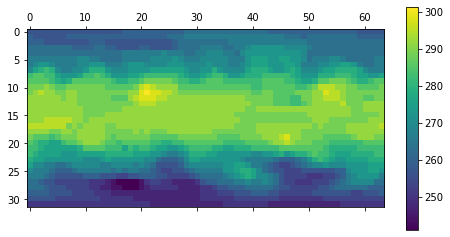

In [38]:
# Most likely bin
plt.matshow(mp[idxs])
plt.colorbar();

In [ ]:
#MAYBE WE CAN IMPROVE THE MOST LIKELY BIN IDEA WITH CERTIFICATIONS
#like binomial_test. if it fails, ABSTAIN from making a prediction.
#we can see where we fail. probably on the high/low latitudes.

In [50]:
# Let's do this for all times and compute the RMSE
das = []
for var in ['z', 't']:
    idxs = np.argmax(preds[var], -1)
    most_likely = preds[var].mid_points[idxs]
    das.append(xr.DataArray(
        most_likely, dims=['time', 'lat', 'lon'],
        coords = [preds.time, preds.lat, preds.lon],
        name=var
    ))
preds_ml = xr.merge(das)

In [52]:
preds_ml

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8722)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float64 5.101e+04 5.101e+04 ... 4.829e+04
    t        (time, lat, lon) float64 256.9 256.9 256.9 ... 247.4 247.4 247.4

In [19]:
datadir=args['datadir']
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [55]:
compute_weighted_rmse(preds_ml, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_rmse   float64 378.0
    t_rmse   float64 2.103

Not particularly good, actually pretty bad but that might have to do with the large bins. Even a perfect model would have at least bin_width/2 error on average.

In [56]:
preds.t.bin_width / 2

1.5881825356331802

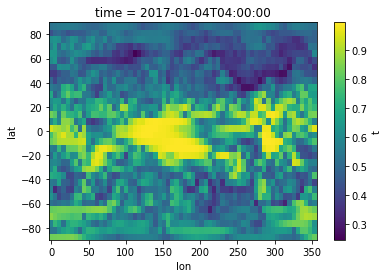

In [57]:
preds.t.isel(time=0).max('bin').plot()

<BarContainer object of 50 artists>

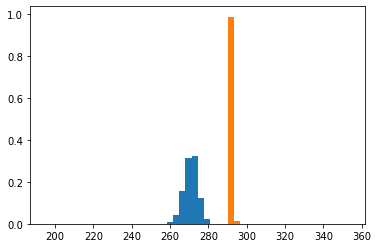

In [60]:
plt.bar(preds.t.mid_points, preds.t.isel(time=0).sel(lat=50, lon=300, method='nearest'), preds.t.bin_width)
plt.bar(preds.t.mid_points, preds.t.isel(time=0).sel(lat=0, lon=150, method='nearest'), preds.t.bin_width)

Seems to learn reasonable distributions.

## Compute bin CRPS

In [103]:
compute_bin_crps(
    obs=4.577418, 
    preds=np.array(
        [0.14935065, 0.15097403, 0.04707792, 0.13149351, 0.10064935, 0.08116883,
         0.11363636, 0.02110390, 0.09902597, 0.10551948]
    ),
    bin_edges = np.arange(0, 11, 1)
)
# Correct

scale = [1 1 1 1 1 1 1 1 1 1]
y_scale =  [1.       1.       1.       1.       0.577418 0.       0.       0.
 0.       0.      ]
z = [1.       1.       1.       1.       0.577418 0.       0.       0.
 0.       0.      ]
a = [0.14935065 0.15097403 0.04707792 0.13149351 0.10064935 0.08116883
 0.11363636 0.0211039  0.09902597 0.10551948]


0.869337668588775

In [15]:
def compute_bin_crps(obs, preds, bin_edges):
    """
    Last axis must be bin axis
    obs: [...]
    preds: [..., n_bins]
    """
    obs = obs.values
    preds = preds.values
    # Convert observation
    a = np.minimum(bin_edges[1:], obs[..., None])
    b = bin_edges[:-1] * (bin_edges[0:-1] > obs[..., None])
    y = np.maximum(a, b)
    # Convert predictions to cumulative predictions with a zero at the beginning
    cum_preds = np.cumsum(preds, -1)
    cum_preds_zero = np.concatenate([np.zeros((*cum_preds.shape[:-1], 1)), cum_preds], -1)
    xmin = bin_edges[..., :-1]
    xmax = bin_edges[..., 1:]
    lmass = cum_preds_zero[..., :-1]
    umass = 1 - cum_preds_zero[..., 1:]
#     y = np.atleast_1d(y)
#     xmin, xmax = np.atleast_1d(xmin), np.atleast_1d(xmax)
#     lmass, lmass = np.atleast_1d(lmass), np.atleast_1d(lmass)
    scale = xmax - xmin
#     print('scale =', scale)
    y_scale = (y - xmin) / scale
#     print('y_scale = ', y_scale)
    
    z = y_scale.copy()
    z[z < 0] = 0
    z[z > 1] = 1
#     print('z =', z)
    a = 1 - (lmass + umass)
#     print('a =', a)
    crps = (
        np.abs(y_scale - z) + z**2 * a - z * (1 - 2*lmass) + 
        a**2 / 3 + (1 - lmass) * umass
    )
    return np.sum(scale * crps, -1)

In [36]:
def compute_weighted_bin_crps(da_fc, da_true, mean_dims=xr.ALL_DIMS):
    """
    """
    t = np.intersect1d(da_fc.time, da_true.time)
    da_fc, da_true = da_fc.sel(time=t), da_true.sel(time=t)
    weights_lat = np.cos(np.deg2rad(da_true.lat))
    weights_lat /= weights_lat.mean()
    dims = ['time', 'lat', 'lon']
    if type(da_true) is xr.Dataset:
        das = []
        for var in da_true:
            result = compute_bin_crps(da_true[var], da_fc[var], da_fc[var].bin_edges)
            das.append(xr.DataArray(
                result, dims=dims, coords=dict(da_true.coords), name=var
            ))
        crps = xr.merge(das)
    else:
        result = compute_bin_crps(da_true, da_fc, da_fc.bin_edges)
        crps = xr.DataArray(
            result, dims=dims, coords=dict(da_true.coords), name=da_fc.name
        )
    crps = (crps * weights_lat).mean(mean_dims)
    return crps

In [17]:
obs = np.ones((100, 32, 64)) * 4.577418
preds_ = np.ones((100, 32, 64, 10)) * np.array(
        [0.14935065, 0.15097403, 0.04707792, 0.13149351, 0.10064935, 0.08116883,
         0.11363636, 0.02110390, 0.09902597, 0.10551948]
    )
bin_edges = np.arange(0, 11, 1)

In [21]:
obs = valid.sel(time='2017-01-05')
preds_ = preds.sel(time='2017-01-05')

In [37]:
compute_weighted_bin_crps(preds_, obs)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 176.6
    t        float64 1.03

In [97]:
obs

<xarray.DataArray 't' (time: 744, lat: 32, lon: 64)>
dask.array<getitem, shape=(744, 32, 64), dtype=float32, chunksize=(744, 32, 64), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-01-31T23:00:00
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [98]:
bin_edges

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [101]:
a = np.minimum(bin_edges[1:], obs.expand_dims('tmp', -1))

ValueError: size of dimension 'tmp' on inputs was unexpectedly changed by applied function from 1 to 10. Only dimensions specified in ``exclude_dims`` with xarray.apply_ufunc are allowed to change size.

In [68]:
b = bin_edges[:-1] * (bin_edges[0:-1] > obs[..., None])

In [69]:
y = np.maximum(a, b)

In [70]:
y[0, 0, 0]

array([1.      , 2.      , 3.      , 4.      , 4.577418, 5.      ,
       6.      , 7.      , 8.      , 9.      ])

In [71]:
cum_preds = np.cumsum(preds, -1)

In [74]:
cum_preds_zero = np.concatenate([np.zeros((*cum_preds.shape[:-1], 1)), cum_preds], -1)

In [75]:
cum_preds_zero.shape

(100, 32, 64, 11)

In [76]:
xmin = bin_edges[..., :-1]
xmax = bin_edges[..., 1:]
lmass = cum_preds_zero[..., :-1]
umass = 1 - cum_preds_zero[..., 1:]

In [77]:
scale = xmax - xmin
y_scale = (y - xmin) / scale

In [78]:
z = y_scale.copy()
z[z < 0] = 0
z[z > 1] = 1
a = 1 - (lmass + umass)

In [79]:
crps = (
    np.abs(y_scale - z) + z**2 * a - z * (1 - 2*lmass) + 
    a**2 / 3 + (1 - lmass) * umass
)

In [80]:
crps.shape

(100, 32, 64, 10)

In [82]:
crps = np.sum(scale * crps, -1)

In [83]:
crps.shape

(100, 32, 64)

## Evaluation

In [14]:
datadir=args['datadir']
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid]).sel(time=preds.time)

In [15]:
ensemblemean=preds.mean('member') #ensemble
mean_rmse_p=compute_weighted_rmse(valid,ensemblemean).load(); print(mean_rmse_p)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_rmse   float64 800.2
    t_rmse   float64 3.798


In [16]:
crps=compute_weighted_crps(preds,valid).load(); print(crps)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 398.8
    t        float64 2.048


In [20]:
spread=compute_weighted_meanspread(preds).load()
spread_skill_z=spread.z_mean_spread/mean_rmse_p.z_rmse
spread_skill_t=spread.t_mean_spread/mean_rmse_p.t_rmse
print(spread_skill_z, spread_skill_t) 

<xarray.DataArray ()>
array(0.92847472) <xarray.DataArray ()>
array(0.89689769)


In [28]:
obs.shape, pred.shape

((2, 1042, 32, 64), (2, 1042, 32, 64, 100))

In [32]:
#!pip install rank-histogram
from ranky import rankz
obs = np.asarray(valid.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.

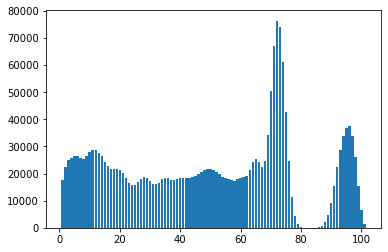

In [39]:
pred=np.asarray(preds.to_array(), dtype=np.float32).squeeze();

shape=pred.shape #maybe we could change shape of pred in create_predcitions() directly
pred2=pred.reshape(shape[0], shape[4],shape[1], shape[2], shape[3])

pred_z500=pred2[0,...].squeeze() 
pred_t850=pred2[1,...].squeeze() 
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show()

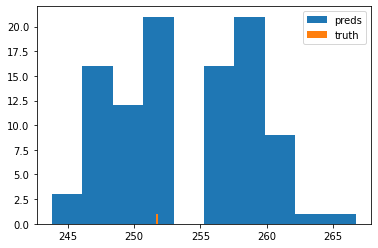

In [51]:
#random point.
plt.hist(pred[1,20,30,40,:], label='preds')
plt.hist(obs[1,20,30,40], label='truth')
plt.legend(loc='upper right')
plt.show()

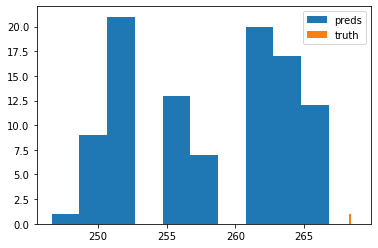

In [53]:
#random point.
plt.hist(pred[1,20,25,30,:], label='preds')
plt.hist(obs[1,20,25,30], label='truth')
plt.legend(loc='upper right')
plt.show()

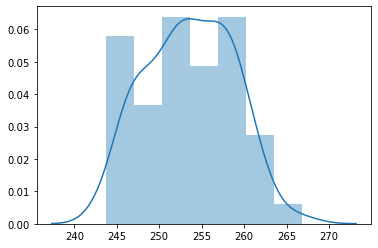

In [57]:
import seaborn
seaborn.distplot(pred[1,20,30,40,:])

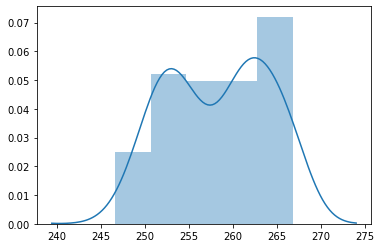

In [58]:
seaborn.distplot(pred[1,20,25,30,:])

In [ ]:
#spread-skill is good. rank histogram weird. 
#density plot doesnt look like a gaussian. 

## Testing code below. Ignore.

In [124]:
dg=dg_valid
level_names = dg.data.isel(level=dg.output_idxs).level_names
level = dg.data.isel(level=dg.output_idxs).level   

In [21]:
x,y=dg_valid[0]
preds=preds=model.predict(dg_valid[0])
print(preds.shape, y.shape)

(32, 32, 64, 2, 50) (32, 32, 64, 2)


In [14]:
bin_min=args['bin_min']; bin_max=args['bin_max']
bins=np.linspace(bin_min, bin_max, num_bins+1)
bins, bins.shape

(array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
        -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
        -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
         1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
         3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ]),
 (51,))

In [15]:
interval=(bin_max-bin_min)/num_bins
print(interval)
bin_mids=np.linspace(bin_min+0.5*interval, bin_max-0.5*interval, num_bins)
bin_mids, bin_mids.shape

0.2


(array([-4.9, -4.7, -4.5, -4.3, -4.1, -3.9, -3.7, -3.5, -3.3, -3.1, -2.9,
        -2.7, -2.5, -2.3, -2.1, -1.9, -1.7, -1.5, -1.3, -1.1, -0.9, -0.7,
        -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,
         1.7,  1.9,  2.1,  2.3,  2.5,  2.7,  2.9,  3.1,  3.3,  3.5,  3.7,
         3.9,  4.1,  4.3,  4.5,  4.7,  4.9]),
 (50,))

In [ ]:
plt.plot(bin_mids, preds[0,30,0,0,:]) #some random point

In [ ]:
plt.plot(bin_mids, preds[10,30,20,0,:]) #some random point

In [134]:
sample=np.random.choice(bin_mids, size=50, p=preds[0,30,0,0,:], replace=True)
sample

array([-0.5, -1.1, -1.7, -1.9, -1.3, -1.7, -1.7, -0.5, -0.5, -1.7, -1.9,
       -1.7, -0.9, -1.1, -1.9, -1.1, -1.7, -1.3, -1.3, -1.1, -1.3, -1.3,
       -1.3, -1.3, -1.3, -1.1, -0.5, -1.7, -0.5, -1.5, -1.7, -1.5, -0.9,
       -1.3, -1.3, -1.3, -0.5, -1.5, -1.9, -1.3, -1.7, -0.9, -0.3, -1.5,
       -1.3, -0.3, -1.1, -1.3, -1.3, -1.1])

(array([ 0.,  0.,  0., 39., 11.,  0.,  0.,  0.,  0.,  0.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 10 Patch objects>)

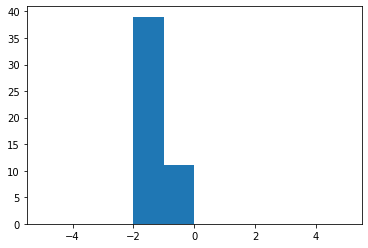

In [135]:
plt.hist(sample, range=(bin_min,bin_max))

In [22]:
member=100
preds_shape=preds.shape
preds=preds.reshape(-1,num_bins)
preds_new=[]
for i, p in enumerate(preds):
    sample=np.random.choice(bin_mids, size=member, p=preds[i,:],replace=True)
    preds_new.append(sample)

In [23]:
preds_new=np.array(preds_new)
print(preds_new.shape)
preds_new3=preds_new.reshape(preds_shape[0],preds_shape[1],
                             preds_shape[2],member, preds_shape[3],)

print(preds_new3.shape)


(131072, 100)
(32, 32, 64, 100, 2)


In [24]:
preds_new=np.array(preds_new)
print(preds_new.shape)
preds_new2=preds_new.reshape(preds_shape[0],preds_shape[1],preds_shape[2],preds_shape[3],member)
print(preds_new2.shape)

(131072, 100)
(32, 32, 64, 2, 100)


In [25]:
preds_new_shape=preds_new2.shape
preds_new2=preds_new2.reshape(preds_new_shape[0],preds_new_shape[1],
                            preds_new_shape[2],
                            preds_new_shape[4],preds_new_shape[3])
print(preds_new2.shape)

(32, 32, 64, 100, 2)


In [20]:
            dg=dg_valid
            preds_new2 = xr.DataArray(
            preds_new2,
            dims=['time', 'lat', 'lon', 'member', 'level'],
            coords={'time': dg.valid_time[0:32], 'lat': dg.data.lat, 
                    'lon': dg.data.lon,
                    'member': np.arange(member),
                    'level': level,
                    'level_names': level_names,
                    },
            )    

NameError: name 'level' is not defined

In [143]:
mean = dg.mean.isel(level=dg.output_idxs).values
std = dg.std.isel(level=dg.output_idxs).values
preds_new2 = preds_new2 * std + mean

In [146]:
unique_vars = list(set([l.split('_')[0] for l in preds_new2.level_names.values]))

In [150]:
    das = []
    for v in unique_vars:
        idxs = [i for i, vv in enumerate(preds_new2.level_names.values) if vv.split('_')[0] in v]
        da = preds_new2.isel(level=idxs).squeeze().drop('level_names')
        if not 'level' in da.dims: da = da.drop('level')
        das.append({v: da})
    preds_final=xr.merge(das)

In [151]:
preds_final

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 100, time: 32)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2017-01-06T18:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables:
    t        (time, lat, lon, member) float64 255.3 275.4 252.4 ... 255.3 249.5
    z        (time, lat, lon, member) float64 4.934e+04 4.997e+04 ... 4.997e+04

In [152]:
preds_final.to_netcdf('/home/garg/data/WeatherBench/predictions/categorical_v3.nc')

In [90]:
sample1=np.random.choice(5, 20, p=[0.05, 0.2, 0.5, 0.2, 0.05])
sample1

array([1, 3, 3, 2, 3, 1, 3, 2, 0, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1])

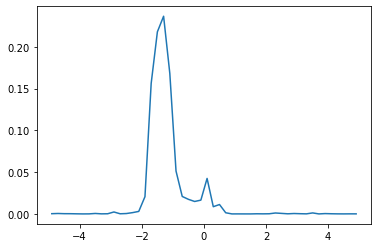

In [153]:
args['datadir']

'/home/garg/data/WeatherBench/5.625deg'

In [155]:
datadir=args['datadir']
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid]).sel(time=preds_final.time)

In [156]:
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 32)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2017-01-06T18:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(32, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(32, 32, 64), meta=np.ndarray>

In [157]:
ensemblemean=preds_final.mean('member') #ensemble
mean_rmse_p=compute_weighted_rmse(valid,ensemblemean).load(); print(mean_rmse_p)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_rmse   float64 3.406e+03
    t_rmse   float64 16.23


In [158]:
crps=compute_weighted_crps(preds_final,valid).load(); print(crps)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 1.796e+03
    t        float64 8.488


In [ ]:
else:
        preds = xr.DataArray(
            model.predict(dg)[0] if multi_dt else model.predict(dg),
            dims=['time', 'lat', 'lon', 'level'],
            coords={'time': dg.valid_time, 'lat': dg.data.lat, 'lon': dg.data.lon,
                    'level': level,
                    'level_names': level_names
                    },
        )  



In [ ]:
    if is_categorical==True:
        #Have to do this weird reshapings else cant sample, unnormalize. Not sure if its correct. Please check.
        preds=model.predict(dg)[0] if multi_dt else model.predict(dg)

        interval=(bin_max-bin_min)/num_bins
        bin_mids=np.linspace(bin_min+0.5*interval, bin_max-0.5*interval, num_bins)

        preds_shape=preds.shape
        preds=preds.reshape(-1,num_bins)
        preds_new=[]
        for i, p in enumerate(preds):
            sample=np.random.choice(bin_mids, size=member,p=preds[i,:],replace=True)
            preds_new.append(sample)

        preds_new=np.array(preds_new)
        preds_new=preds_new.reshape(preds_shape[0],preds_shape[1],preds_shape[2],
                                    preds_shape[3],member)
        
        preds_new_shape=preds_new.shape
        preds_new=preds_new.reshape(preds_new_shape[0],preds_new_shape[1],
                                    preds_new_shape[2],preds_new_shape[4],
                                    preds_new_shape[3],
                                    
        preds = xr.DataArray(
            preds_new,
            dims=['time', 'lat', 'lon', 'member', 'level'],
            coords={'time': dg.valid_time, 'lat': dg.data.lat, 'lon': dg.data.lon,
                    'member': np.arange(member),
                    'level': level,
                    'level_names': level_names,
                    },)



In [ ]:
if is_categorical==True:
        
        #Have to do this weird reshapings else cant sample, unnormalize. 
        #Not sure if its correct. Please check.
        preds=model.predict(dg)[0] if multi_dt else model.predict(dg)

        interval=(bin_max-bin_min)/num_bins
        bin_mids=np.linspace(bin_min+0.5*interval, bin_max-0.5*interval, num_bins)

        preds_shape=preds.shape
        preds=preds.reshape(-1,num_bins)
        preds_new=[]
        for i, p in enumerate(preds):
            sample=np.random.choice(bin_mids, size=member,p=preds[i,:],replace=True)
            preds_new.append(sample)

        preds_new=np.array(preds_new)
        preds_new=preds_new.reshape(preds_shape[0],preds_shape[1],preds_shape[2],
                                    preds_shape[3],member)
        
        preds_new_shape=preds_new.shape
        preds_new=preds_new.reshape(preds_new_shape[0],preds_new_shape[1],
                                    preds_new_shape[2],preds_new_shape[4],
                                    preds_new_shape[3],
                                    
        preds = xr.DataArray(
            preds_new,
            dims=['time', 'lat', 'lon', 'member', 'level'],
            coords={'time': dg.valid_time, 'lat': dg.data.lat, 'lon': dg.data.lon,
                    'member': np.arange(member),
                    'level': level,
                    'level_names': level_names,
                    },)
    